In [1]:
import pathlib
import nibabel as nib
from preprocessing import scale_to_reference_img, normalize, apply_FLIRT
import nipype.interfaces.fsl as fsl

import os, shutil
os.environ["FSLDIR"] = os.path.expanduser("~/fsl")
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
os.environ["PATH"] = os.path.join(os.environ["FSLDIR"], "bin") + os.pathsep + os.environ.get("PATH","")


/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

DATA_DIR = pathlib.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(DATA_DIR.rglob("*T2w_LR.nii.gz"))
files = list(zip(t1_files, t2_files, t2_LR_files))

template_img = pathlib.Path.home()/"GAMBAS"/"Template.nii.gz"
#pp_img = pathlib.Path.home()/"FLIRT_processed"/"label"/"0.nii.gz"



In [4]:
out_labels_dir = pathlib.Path.home()/"FLIRT_processed"/"Training_data"/"labels"
out_images_dir = pathlib.Path.home()/"FLIRT_processed"/"Training_data"/"images"
for i in range(len(t2_files)):
    apply_FLIRT(t2_files[i], template_img, out_labels_dir / f"{i}.nii.gz")
    apply_FLIRT(t2_LR_files[i], template_img, out_images_dir / f"{i}.nii.gz")


In [37]:
# Use FLIRT to register / resample the T2 image to the template.
# Convert pathlib.Path to str for nipype compatibility and avoid command interpolation errors.
flirt = fsl.FLIRT()
flirt.inputs.in_file = str(t2_files[0])
flirt.inputs.reference = str(template_img)
flirt.inputs.out_file = str(pp_img)
# Optionally set parameters, e.g. flirt.inputs.dof = 6
res = flirt.run()
print(res.runtime.stdout)

Template max: 132.0
Template min: 0.0
t2 LR max: 135.08783686755243
t2 LR min: -14.827060224676805
new t2 LR max: 1.0
new t2 LR min: 0.0


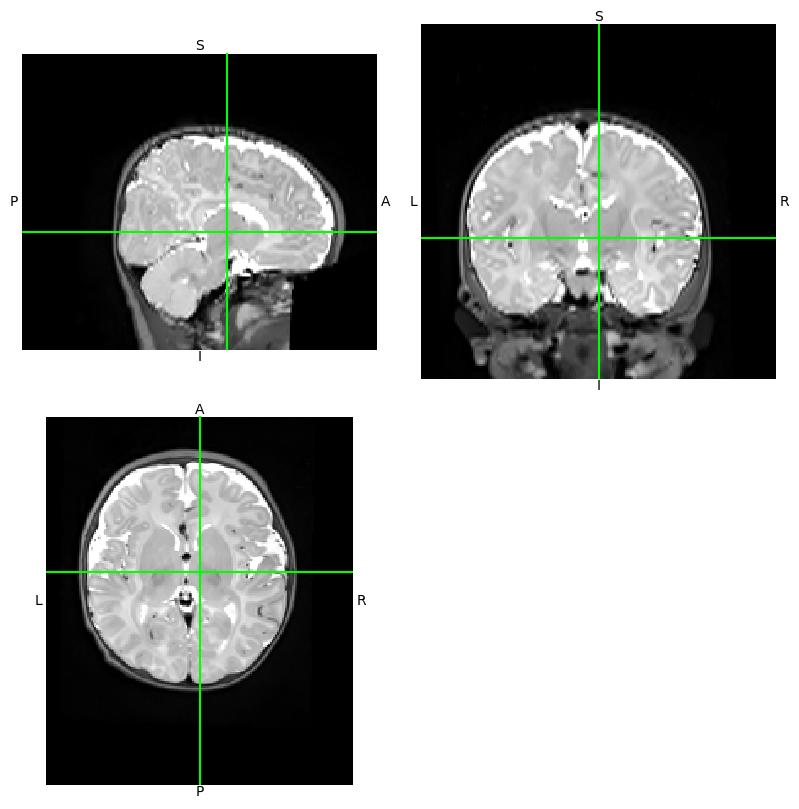

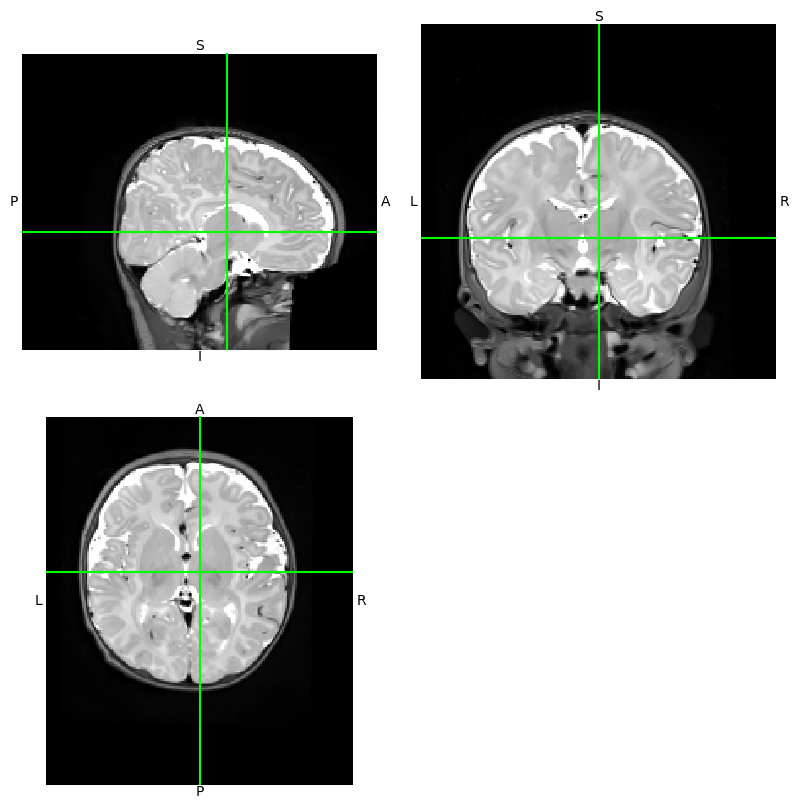

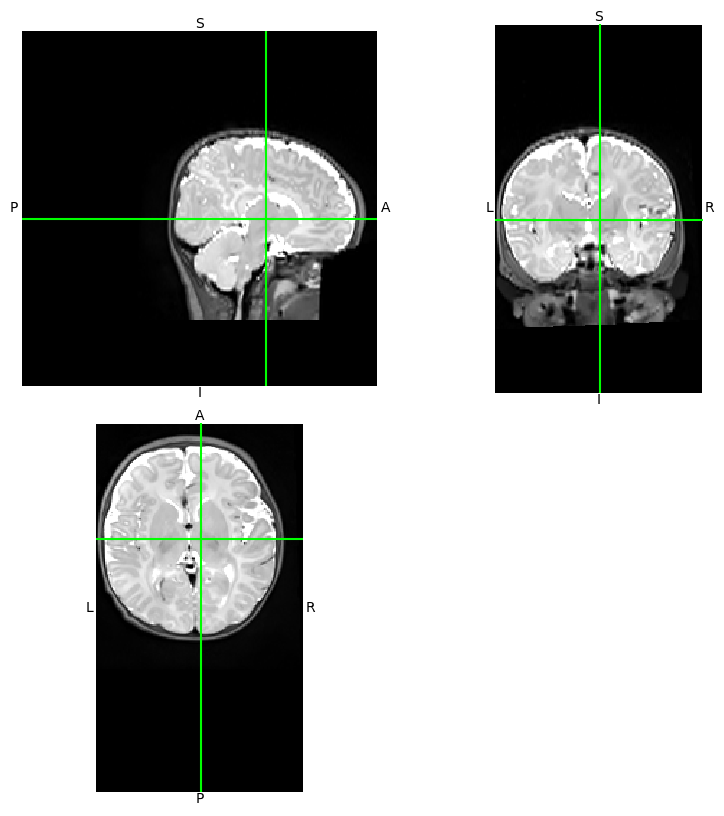

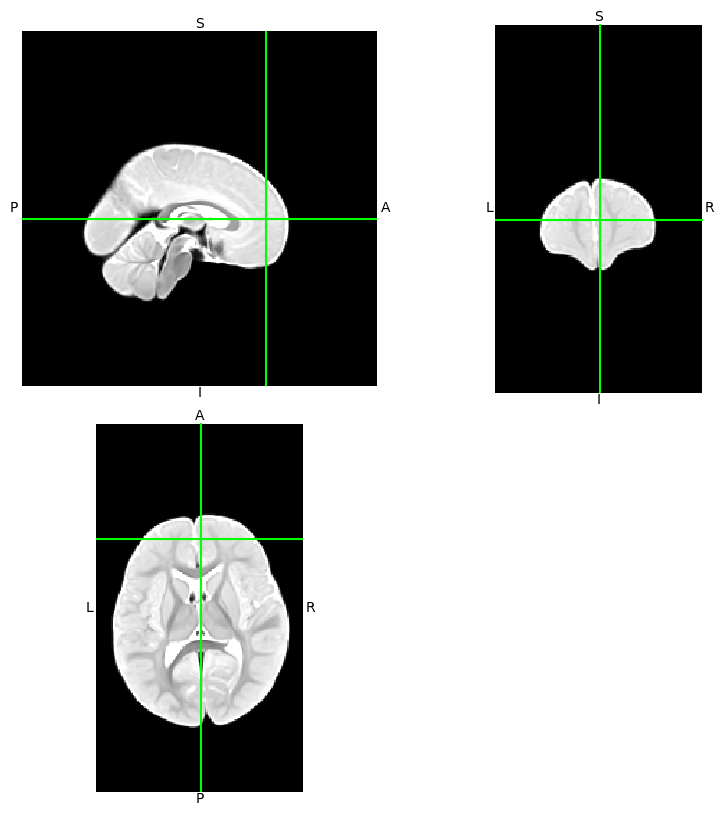

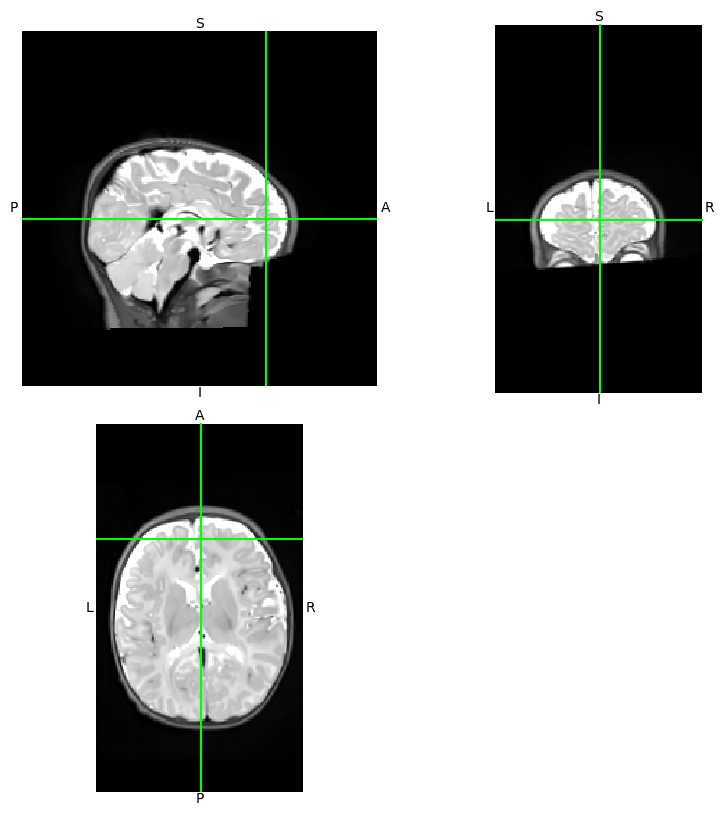

In [38]:
t2_lr = nib.load(t2_LR_files[0])
t2_hr = nib.load(t2_files[0])
tem = nib.load(template_img)
pp = nib.load(pp_img)

new_t2_lr = scale_to_reference_img(t2_lr, tem)
new_t2_lr = normalize(new_t2_lr)

#print(new_t2_lr)

t2_lr.orthoview()
t2_hr.orthoview()
new_t2_lr.orthoview()
tem.orthoview()
pp.orthoview()

#print max and min pixel value of template
print("Template max:", tem.get_fdata().max())
print("Template min:", tem.get_fdata().min())

print("t2 LR max:", t2_lr.get_fdata().max())
print("t2 LR min:", t2_lr.get_fdata().min())
print("new t2 LR max:", new_t2_lr.get_fdata().max())
print("new t2 LR min:", new_t2_lr.get_fdata().min())

def clip_neg_values(img):
    data = img.get_fdata()
    data[data < 0] = 0
    return nib.Nifti1Image(data, img.affine, img.header)